In [13]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone

In [14]:
start_day_to_analyze = '2020-03-27'
end_day_to_analyze = '2020-03-28'

In [15]:
base_url = "https://api.alpaca.markets"
api_key_id = "PKO3OSD9LU9GTQPL69GO"
api_secret = "chnPFlGXbY4Y4QAAZ3Q7MJHxkxBYB30CQZNVZTaj"

In [16]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [17]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [18]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [19]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [20]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [21]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [22]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,121,algo.py,PAPER,v0.1-153-g4a30d48,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-03-27 13:45:20.419822,None,None


,symbol,count,revenue
9,CTK,2,-112.21
8,SPXS,2,-60.50
15,TECS,2,-51.68
2,SPWH,5,-46.27
12,FNGD,2,-45.79
16,APVO,2,-43.40
6,SDC,3,-28.70
14,LABD,2,-27.37
5,TLRY,3,-14.64
10,SPKE,2,-9.36


TOTAL REVENUE: -254.93 $


In [23]:
minute_history = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = start_day_to_analyze,
                to=end_day_to_analyze,limit=5000).df

TCRD analysis for run 121 with profit 106.19


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-1016.50,-1016.50,buy,2020-03-27 13:56:15.495848,2.14,475,"{'rsi': 71.48910392158496, 'macd': [0.027657845585995045, 0.027538671020734373, 0.03032235281694673, 0.03454293140011089, 0.03746397808036628], 'sell_macd': [0.017427233653333207, 0.017234461507944054, 0.018938347349096052, 0.021573344792213067, 0.0233516110492884], 'slow macd': [-8.906245531470347e-05, 0.0009188769072712155, 0.002484487849166772, 0.00439913512062029, 0.006155235412955928], 'macd_signal': [0.022931449231994222, 0.02385289358974225, 0.025146785435183148, 0.027026014628168695, 0.029113607318608212], 'sell_macd_signal': [0.01480895242943899, 0.015294054245140003, 0.016022912865931212, 0.017132999251187584, 0.018376721610807747]}",2.65,1.97
1,-653.10,363.40,sell,2020-03-27 14:03:21.319939,2.30,158,"{'rsi': 79.07799140252332, 'macd': [0.026022199016381364, 0.027189074894895082, 0.02878418499640034, 0.03121174890671119, 0.03685385391595686], 'reasons': 'scale-out AND rsi max', 'movement': 0.0269518812502802, 'macd_signal': [0.020237453455558864, 0.021627777743426106, 0.023059059194020952, 0.024689597136559, 0.027122448492438573]}",2.65,1.97
2,76.00,729.10,sell,2020-03-27 14:03:25.876571,2.30,317,"{'rsi': 79.69534057607716, 'macd': [0.027189074894895082, 0.02878418499640034, 0.03121174890671119, 0.03685385391595686, 0.041291158417759544], 'reasons': 'rsi max', 'movement': 0.004366812227074143, 'macd_signal': [0.021627777743426106, 0.023059059194020952, 0.024689597136559, 0.027122448492438573, 0.029956190477502767]}",2.65,1.97
3,-213.38,-289.38,buy,2020-03-27 14:12:36.711972,2.73,106,"{'rsi': 72.94995039028622, 'macd': [0.09359721583905145, 0.13281619854232352, 0.14049128529226795, 0.15567272037792534, 0.16938270262021637], 'sell_macd': [0.058737764523368874, 0.08396976188204963, 0.08851456811112479, 0.09791942272974019, 0.10631386239710627], 'slow macd': [0.028303401639147463, 0.03883179633155187, 0.0441378774998431, 0.05110818587978638, 0.05815906426392514], 'macd_signal': [0.058869494594942604, 0.07365883538441878, 0.08702532536598862, 0.10075480436837596, 0.11448038401874404], 'sell_macd_signal': [0.03679302476719543, 0.046228372190166275, 0.05468561137435798, 0.06333237364543443, 0.07192867139576879]}",5.01,1.97
4,-113.98,99.40,sell,2020-03-27 14:12:56.266316,2.84,35,"{'rsi': 74.88855192416834, 'macd': [0.058737764523368874, 0.08396976188204963, 0.08851456811112479, 0.09791942272974019, 0.11046970655295052], 'reasons': 'scale-out', 'movement': 0.029304029304029332, 'macd_signal': [0.03679302476719543, 0.046228372190166275, 0.05468561137435798, 0.06333237364543443, 0.07275984022693764]}",5.01,1.97
5,-48.20,65.78,sell,2020-03-27 14:13:15.606845,2.86,23,"{'rsi': 76.18969567541015, 'macd': [0.08396976188204963, 0.08851456811112479, 0.09791942272974019, 0.11254762863087242, 0.1234975601300552], 'reasons': 'scale-out', 'movement': 0.021174377224199247, 'macd_signal': [0.046228372190166275, 0.05468561137435798, 0.06333237364543443, 0.07317542464252202, 0.08323985174002865]}",5.01,1.97
6,-0.84,47.36,sell,2020-03-27 14:14:32.130404,2.96,16,"{'rsi': 75.85706286438753, 'macd': [0.08851456811112479, 0.09791942272974019, 0.11254762863087242, 0.11988717051966535, 0.1318415256210672], 'reasons': 'scale-out', 'movement': 0.02805366788639144, 'macd_signal': [0.05468561137435798, 0.06333237364543443, 0.07317542464252202, 0.0825177738179507, 0.092382524178574]}",5.01,1.97
7,31.36,32.20,sell,2020-03-27 14:25:03.098549,3.22,10,"{'rsi': 70.73247137049837, 'macd': [0.11471019791353188, 0.11001661613946911, 0.10598503792410208, 0.10637621025077593, 0.11699821193064164], 'reasons': 'scale-out', 'movement': 0.029126213592233108, 'macd_signal': [0.11992493958170179, 0.11794327489325526, 0.11555162749942463, 0.11371654404969489, 0.11437287762588425]}",5.01,1.97
8,54.88,23.52,sell,2020-03-27 14:25:08.038259,3.36,7,"{'rsi': 72.95259643403608, 'macd': [0.11001661613946911, 0.10598503792410208, 0.10637621025077593

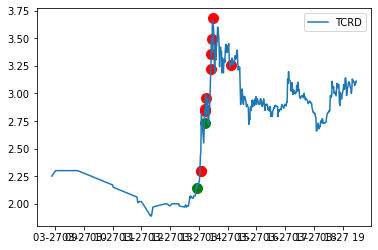

INO analysis for run 121 with profit 43.26


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-1081.42,-1081.42,buy,2020-03-27 13:47:07.281877,7.78,139,"{'rsi': 74.87605453680362, 'macd': [0.1273933517931587, 0.128923355999083, 0.13024830680430455, 0.136989526873303, 0.1422974397265273], 'sell_macd': [0.07814098580707896, 0.07873978129428405, 0.07922274165711496, 0.08325072711312487, 0.08634200503841694], 'slow macd': [0.0576652028856639, 0.06119649521211201, 0.06466739391755372, 0.06919832888178767, 0.07357453361476463], 'macd_signal': [0.1182528597384277, 0.12038695899055876, 0.12235922855330791, 0.12528528821730694, 0.128687718519151], 'sell_macd_signal': [0.0738872699781828, 0.07485777224140305, 0.07573076612454543, 0.07723475832226132, 0.07905620766549244]}",9.52,7.20
1,13.90,1095.32,sell,2020-03-27 13:48:14.678720,7.88,139,"{'rsi': 78.53346398063535, 'macd': [0.07873978129428405, 0.07922274165711496, 0.08325072711312487, 0.08997836867477993, 0.09561057809068352], 'reasons': 'rsi max', 'movement': 0.012853470437017948, 'macd_signal': [0.07485777224140305, 0.07573076612454543, 0.07723475832226132, 0.07978348039276503, 0.08294889993234873]}",9.52,7.20
2,-703.44,-717.34,buy,2020-03-27 13:52:08.464979,8.06,89,"{'rsi': 73.5548120613633, 'macd': [0.16549904265816906, 0.19696010277200582, 0.21856680112020221, 0.22183624511243405, 0.22346516852386955], 'sell_macd': [0.10106512354522845, 0.12111889196966619, 0.13465275188520653, 0.13617715244426076, 0.13663542362736436], 'slow macd': [0.08179003154022713, 0.09210614950750173, 0.10129006108073924, 0.10733844983951446, 0.1130513601692158], 'macd_signal': [0.1369434306404018, 0.1489467650667226, 0.16287077227741853, 0.17466386684442164, 0.18442412718031123], 'sell_macd_signal': [0.08403980902325772, 0.09145562561253942, 0.10009505086707285, 0.10731147118251043, 0.11317626167148122]}",10.80,7.20
3,-16.36,687.08,sell,2020-03-27 14:18:10.236364,7.72,89,"{'rsi': 38.90469227710113, 'macd': [0.021805368893353716, 0.02007732345962765, 0.01639732281698958, 0.00915579864328464, -0.001800659136788063], 'reasons': 'below cost & macd negative', 'movement': -0.04567901234567892, 'macd_signal': [0.03269188923273063, 0.030168976078110032, 0.027414645425885942, 0.023762876069365682, 0.018650169028134933]}",10.80,7.20
4,-2378.46,-2362.10,buy,2020-03-27 14:53:16.800373,7.90,299,"{'rsi': 63.43674449447085, 'macd': [-0.02736343792485041, -0.01941953745072489, -0.012974378532812025, -0.005750685608147066, 0.0051277140975942714], 'sell_macd': [-0.017329848778673274, -0.01203563938529495, -0.007753974411424558, -0.0029974306082607427, 0.004103738986519723], 'slow macd': [0.0288235664845109, 0.0285682183001974, 0.028287598929823687, 0.028390415576385664, 0.029472790403027638], 'macd_signal': [-0.021929313050952408, -0.021427357930906905, -0.01973676205128793, -0.016939546762659758, -0.012526094590608952], 'sell_macd_signal': [-0.014315980003160006, -0.013859911879586994, -0.012638724385954507, -0.010710465630415753, -0.007747624707028658]}",8.74,7.66
5,-1558.74,819.72,sell,2020-03-27 15:34:11.535425,8.28,99,"{'rsi': 70.89286205970818, 'macd': [0.0281434842006707, 0.030536024628299074, 0.03262714671959088, 0.03528740878138237, 0.04001894533886308], 'reasons': 'scale-out', 'movement': 0.020987654320987648, 'macd_signal': [0.02688293155688457, 0.02761355017116747, 0.028616269480852153, 0.029950497340958195, 0.03196418694053917]}",8.74,7.66
6,43.26,1602.00,sell,2020-03-27 15:44:55.171882,8.01,200,"{'rsi': 38.390015517563235, 'macd': [0.03183686552319642, 0.02671525209739478, 0.016663147452646854, 0.009133414645667415, -0.0004888890304943772], 'reasons': 'below cost & macd negative', 'movement': -0.036275695284159595, 'macd_signal': [0.03810230653692894, 0.03582489564902211, 0.03199254600974706, 0.02742071973693113, 0.02183879798344603]}",8.74,7.66


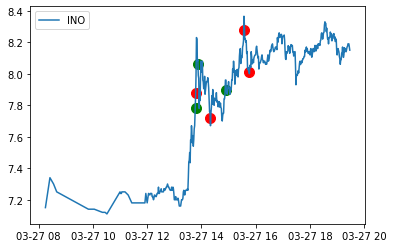

SPWH analysis for run 121 with profit -46.27


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-1605.93,-1605.93,buy,2020-03-27 13:48:56.610911,5.97,269,"{'rsi': 53.197963546405994, 'macd': [0.07309768846545328, 0.07536302092182989, 0.08066648058512449, 0.08430119706679307, 0.08977795559725354], 'sell_macd': [0.04594425511637734, 0.04715822779923595, 0.05034887887939554, 0.05244095921615077, 0.05572776260562051], 'slow macd': [0.022715963387619276, 0.025233747661841832, 0.028389480018633506, 0.03132741773670844, 0.03470002270205974], 'macd_signal': [0.05158427466817318, 0.056340023918904525, 0.06120531525214852, 0.06582449161507743, 0.07061518441151265], 'sell_macd_signal': [0.032630408947237004, 0.035535972717636796, 0.038498553949988544, 0.04128703500322099, 0.0441751805237009]}",6.89,5.69
1,-1059.47,546.46,sell,2020-03-27 13:55:32.142267,6.14,89,"{'rsi': 60.77420706090053, 'macd': [0.06034494898894227, 0.058829430607498345, 0.05636500809458678, 0.05791006836901236, 0.062216478084550886], 'reasons': 'scale-out', 'movement': 0.0242070116861435, 'macd_signal': [0.05187776975210488, 0.053268101923183576, 0.053887483157464215, 0.05469200019977384, 0.05619689577672925]}",6.89,5.69
2,-2.87,1056.60,sell,2020-03-27 14:16:08.139590,5.87,180,"{'rsi': 41.803014134710125, 'macd': [0.006377267307169809, 0.006828480334818643, 0.004753731001366113, 0.0025558259233333658, -0.0012679420066055158], 'reasons': 'below cost & macd negative', 'movement': -0.044824775876120534, 'macd_signal': [0.010749710956016975, 0.009965464831777309, 0.00892311806569507, 0.007649659637222729, 0.0058661393084570804]}",6.89,5.69
3,-1881.47,-1878.60,buy,2020-03-27 14:25:23.774307,6.06,310,"{'rsi': 62.29946514332156, 'macd': [-0.005796776003805348, 0.00426517335989729, 0.01728504624188698, 0.025693379169465125, 0.031988302355807186], 'sell_macd': [-0.005840440051339435, 0.0009033391438997285, 0.00952312372273667, 0.015077201008548258, 0.019209245633745375], 'slow macd': [0.03411753420810015, 0.035110766241927216, 0.037008000886016745, 0.038374456268866375, 0.03957026434997868], 'macd_signal': [-0.002334437945657867, -0.0010145156845468356, 0.0026453967007399283, 0.007254993194484968, 0.01220165502674941], 'sell_macd_signal': [-0.004437014699537603, -0.0033689439308501367, -0.0007905304001327752, 0.0023830158816034314, 0.00574826183203182]}",6.84,5.80
4,-46.27,1835.20,sell,2020-03-27 14:52:06.137942,5.92,310,"{'rsi': 40.223892514459706, 'macd': [0.008993977905093153, 0.006410974232093025, 0.004314984691676571, 2.830472912229709e-05, -0.003831813484934443], 'reasons': 'below cost & macd negative', 'movement': -0.01815181518151806, 'macd_signal': [0.014380598439114234, 0.012786673597709993, 0.011092335816503308, 0.008879529599027106, 0.006337260982234796]}",6.84,5.80


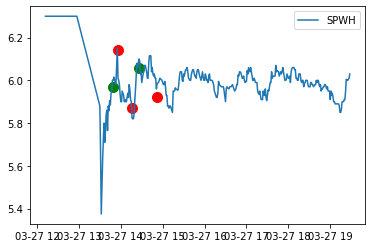

JDST analysis for run 121 with profit 24.1


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-1141.30,-1141.30,buy,2020-03-27 14:04:27.020902,2.26,505,"{'rsi': 67.14756894359668, 'macd': [0.02745061225483969, 0.029299530616472946, 0.0312438452232624, 0.034804275810083496, 0.03719715702984239], 'sell_macd': [0.015289237788286947, 0.01650968741482073, 0.01778653533920016, 0.020108929366779105, 0.021657432123765474], 'slow macd': [0.03196296230623519, 0.03257803431047046, 0.033258149682123594, 0.03431049389301721, 0.03522380938829661], 'macd_signal': [0.03094894258716699, 0.03061906019302818, 0.030744017199075026, 0.03155606892127672, 0.032684286542989854], 'sell_macd_signal': [0.017653077334730722, 0.017424399350748722, 0.01749682654843901, 0.018019247112107027, 0.018746884114438717]}",2.74,2.1
1,-753.22,388.08,sell,2020-03-27 14:20:49.448604,2.31,168,"{'rsi': 71.61643337571539, 'macd': [0.012980065395669538, 0.013290723778359048, 0.013360188443073628, 0.014799249370863077, 0.01676735854354483], 'reasons': 'scale-out', 'movement': 0.022123893805309856, 'macd_signal': [0.014858100646810177, 0.014544625273119952, 0.014307737907110688, 0.014406040199861166, 0.0148783038685979]}",2.74,2.1
2,-488.90,264.32,sell,2020-03-27 14:33:46.268774,2.36,112,"{'rsi': 66.9784146359772, 'macd': [0.01767074022370796, 0.018570270856033133, 0.017471589909065166, 0.017334025665855624, 0.018134183065096288], 'reasons': 'bail AND scale-out', 'movement': 0.021645021645021568, 'macd_signal': [0.018388078312617216, 0.018424516821300398, 0.01823393143885335, 0.018053950284253807, 0.018069996840422303]}",2.74,2.1
3,24.10,513.00,sell,2020-03-27 14:47:07.400240,2.28,225,"{'rsi': 42.56408992576855, 'macd': [0.009393636987041099, 0.005711560022570783, 0.0038175836863270085, 0.0007233477920287612, -0.0016919444345937507], 'reasons': 'below cost & macd negative', 'movement': -0.033855932203389776, 'macd_signal': [0.016048400274338945, 0.013981032223985312, 0.011948342516453651, 0.009703343571568674, 0.007424285970336189]}",2.74,2.1


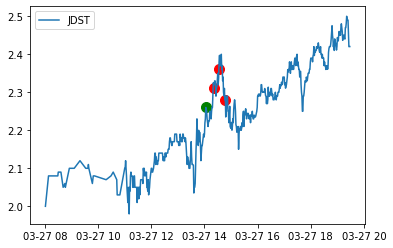

DUST analysis for run 121 with profit 20.58


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-844.34,-844.34,buy,2020-03-27 14:03:32.350493,2.59,326,"{'rsi': 67.16893779284948, 'macd': [0.026423986653854037, 0.026636307597943, 0.02809454984646953, 0.03127813508566879, 0.03505127867665747], 'sell_macd': [0.015292448693209781, 0.015409296026158703, 0.01633918620733743, 0.018389241073095697, 0.02081280017533471], 'slow macd': [0.022729542507393674, 0.023194904979351172, 0.023905828381213023, 0.024995077255327125, 0.026285113780843083], 'macd_signal': [0.027302539522030395, 0.027169293137212915, 0.02735434447906424, 0.02813910260038515, 0.029521537815639615], 'sell_macd_signal': [0.01605385425511081, 0.01592494260932039, 0.0160077913289238, 0.01648408127775818, 0.017349825057273484]}",3.34,2.35
1,-550.58,293.76,sell,2020-03-27 14:34:09.614918,2.72,108,"{'rsi': 73.42849062409094, 'macd': [0.01313445620918019, 0.012613525902308353, 0.013342495456663883, 0.01555542633724416, 0.017597250057991953], 'reasons': 'bail AND scale-out', 'movement': 0.02255639097744363, 'macd_signal': [0.015363761663125813, 0.014813714510962321, 0.014519470700102633, 0.014726661827530938, 0.015300779473623141]}",3.34,2.35
2,20.58,571.16,sell,2020-03-27 14:47:07.641816,2.62,218,"{'rsi': 43.57132058830203, 'macd': [0.009042897702898234, 0.005254719673279062, 0.003268415758338694, 0.0006392384771078952, -0.001158032631346284], 'reasons': 'below cost & macd negative', 'movement': -0.034926470588235364, 'macd_signal': [0.014072411802115674, 0.012308873376348351, 0.01050078185274642, 0.008528473177618715, 0.006591172015825715]}",3.34,2.35


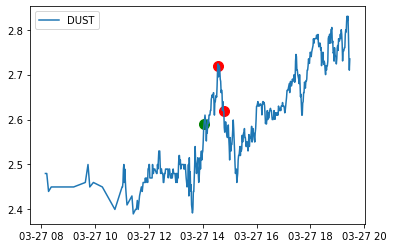

TLRY analysis for run 121 with profit -14.64


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-727.92,-727.92,buy,2020-03-27 14:02:17.765220,10.11,72,"{'rsi': 69.50616300437018, 'macd': [0.27635493039776904, 0.27967009468718906, 0.279072344832036, 0.2853952206454409, 0.30604254248619434], 'sell_macd': [0.15626367832261145, 0.15839342641869258, 0.15799071809851384, 0.16211859839319942, 0.175567354487848], 'slow macd': [0.2496119010568556, 0.2546753061383953, 0.2589248838545348, 0.2644197174368692, 0.27285071831779995], 'macd_signal': [0.3142216282234808, 0.3073113215162225, 0.3016635261793852, 0.2984098650725963, 0.2999364005553159], 'sell_macd_signal': [0.18275695002452, 0.1778842453033545, 0.17390553986238638, 0.171548151568549, 0.1723519921524088]}",13.48,8.99
1,-480.24,247.68,sell,2020-03-27 14:03:47.226826,10.32,24,"{'rsi': 73.02973929978566, 'macd': [0.15839342641869258, 0.15799071809851384, 0.16211859839319942, 0.17264787396836745, 0.19230902540397388], 'reasons': 'scale-out', 'movement': 0.02051915945611862, 'macd_signal': [0.1778842453033545, 0.17390553986238638, 0.171548151568549, 0.17176809604851268, 0.17587628191960492]}",13.48,8.99
2,-14.64,465.60,sell,2020-03-27 14:31:10.375001,9.70,48,"{'rsi': 41.51133661767932, 'macd': [0.029400201024433414, 0.027190503121367726, 0.022518134584933236, 0.012091378133362696, -0.002933255181281069], 'reasons': 'below cost & macd negative', 'movement': -0.08646502835538748, 'macd_signal': [0.037655433774747595, 0.03556244764407162, 0.032953585032243944, 0.028781143652467693, 0.02243826388571794]}",13.48,8.99


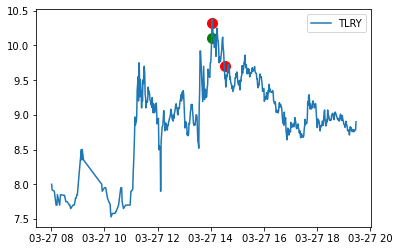

SDC analysis for run 121 with profit -28.7


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-750.20,-750.20,buy,2020-03-27 14:01:03.425186,6.05,124,"{'rsi': 69.24154046947353, 'macd': [0.12597942915780358, 0.12483965597781932, 0.12485334187979369, 0.13070847081290982, 0.1474313385432664], 'sell_macd': [0.07271211530171051, 0.07184446256881483, 0.0717522076786512, 0.07548094143074913, 0.08627890355665979], 'slow macd': [0.0870274222871803, 0.08946329201898262, 0.09202829925001144, 0.09569801873885364, 0.10165292976199325], 'macd_signal': [0.14078943710936218, 0.1375994808830536, 0.13505025308240162, 0.13418189662850327, 0.1368317850114559], 'sell_macd_signal': [0.08371671462718926, 0.08134226421551437, 0.07942425290814173, 0.0786355906126632, 0.08016425320146252]}",8.0,5.4
1,-496.82,253.38,sell,2020-03-27 14:15:09.507074,6.18,41,"{'rsi': 66.01448546383733, 'macd': [0.06609435265137442, 0.06591234408190516, 0.0645508783903459, 0.06600232228795733, 0.07160081984079802], 'reasons': 'scale-out', 'movement': 0.021487603305785107, 'macd_signal': [0.07398285822929854, 0.07236875539981986, 0.07080517999792507, 0.06984460845593152, 0.07019585073290482]}",8.0,5.4
2,-28.70,468.12,sell,2020-03-27 14:20:07.366496,5.64,83,"{'rsi': 39.35489104570482, 'macd': [0.06083183038372031, 0.053803944194137365, 0.0331873582776554, 0.014249923040427603, -0.0006915839371588461], 'reasons': 'below cost & macd negative', 'movement': -0.08737864077669903, 'macd_signal': [0.06797147998827162, 0.06513797282944477, 0.058747849919086895, 0.04984826454335504, 0.039740294847252264]}",8.0,5.4


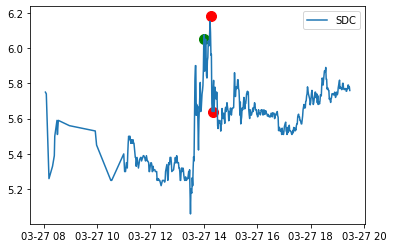

DVAX analysis for run 121 with profit 3.52


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-1030.27,-1030.27,buy,2020-03-27 13:49:36.809669,3.83,269,"{'rsi': 61.77811155034919, 'macd': [0.05115297123001783, 0.053202197753139835, 0.053403703459253826, 0.05454843068245685, 0.05721682459599231], 'sell_macd': [0.03233676732319202, 0.0334614719961821, 0.03338382015700292, 0.03392871716339618, 0.03547112110132078], 'slow macd': [0.01369910281313036, 0.015600813563363403, 0.017165560937226765, 0.018897596708322695, 0.020940709032376326], 'macd_signal': [0.03993416913873796, 0.042587774861618334, 0.04475096058114543, 0.046710454601407714, 0.048811728600324636], 'sell_macd_signal': [0.025731792680281303, 0.027277728543461464, 0.028498946866169755, 0.02958490092561504, 0.030762144960756188]}",4.74,3.54
1,-682.28,347.99,sell,2020-03-27 14:05:53.952014,3.91,89,"{'rsi': 66.2147384974827, 'macd': [0.02842652252922928, 0.028420080887073595, 0.02778622920634133, 0.026671718426467095, 0.02738935004700105], 'reasons': 'bail AND scale-out', 'movement': 0.020104166666666652, 'macd_signal': [0.03242031601581345, 0.03162026899006548, 0.03085346103332065, 0.03001711251194994, 0.02949156001896016]}",4.74,3.54
2,3.52,685.80,sell,2020-03-27 14:21:10.397472,3.81,180,"{'rsi': 39.72796045823869, 'macd': [0.01257346708498197, 0.009817745668549538, 0.007023446569140557, 0.0029418700427292777, -0.0005417203680164739], 'reasons': 'below cost & macd negative', 'movement': -0.029919330133769014, 'macd_signal': [0.01609198757780978, 0.014837139195957732, 0.013274400670594298, 0.011207894545021293, 0.00885797156241374]}",4.74,3.54


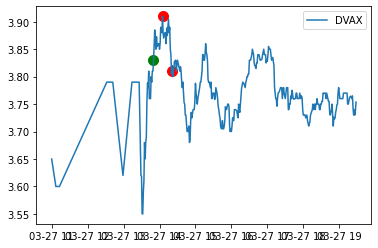

SPXS analysis for run 121 with profit -60.5


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-1908.5,-1908.5,buy,2020-03-27 13:48:06.966672,17.35,110,"{'rsi': 69.26515320939927, 'macd': [0.2785044863581305, 0.2782431370023808, 0.278265804749271, 0.28427027885581424, 0.28733851037683067], 'sell_macd': [0.1765385666983832, 0.1751837567653105, 0.1740659340023285, 0.17689794309607976, 0.17785148338866108], 'slow macd': [0.06955229549542352, 0.07774759899155725, 0.08584452140204846, 0.09499271827566957, 0.10357889585787916], 'macd_signal': [0.21817948898098072, 0.23019221858526073, 0.23980693581806278, 0.24869960442561306, 0.2564273856158566], 'sell_macd_signal': [0.1413292860420246, 0.14810018018668178, 0.15329333094981112, 0.15801425337906486, 0.1619816993809841]}",19.54,16.62
1,-60.5,1848.0,sell,2020-03-27 14:09:02.268569,16.80,110,"{'rsi': 39.0025456051085, 'macd': [0.027216867895749175, 0.019763570958943433, 0.01571991658014582, 0.009247979186536526, -0.0005905172135065584], 'reasons': 'below cost & macd negative', 'movement': -0.031700288184438076, 'macd_signal': [0.0507092132181916, 0.044520084766341964, 0.03876005112910273, 0.03285763674058949, 0.026168005949770277]}",19.54,16.62


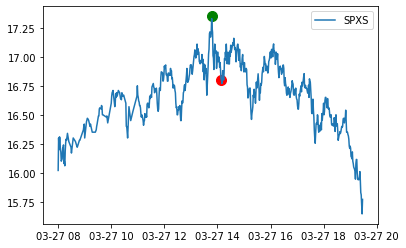

CTK analysis for run 121 with profit -112.21


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-1609.87,-1609.87,buy,2020-03-27 14:00:03.084949,7.03,229,"{'rsi': 64.25547802548714, 'macd': [0.16025975191268937, 0.15987007495794447, 0.15694517050669976, 0.1592467961302919, 0.16162844815868738], 'sell_macd': [0.10109786771611429, 0.10012315831311636, 0.09754386321580455, 0.0984230636176946, 0.09938837479296314], 'slow macd': [0.013404491747295744, 0.0188379848859066, 0.023646907625771263, 0.02931293865093121, 0.034958794562282236], 'macd_signal': [0.14353924698142012, 0.146805412576725, 0.14883336416271994, 0.15091605055623433, 0.15305853007672493], 'sell_macd_signal': [0.09358239092641203, 0.0948905444037529, 0.09542120816616323, 0.09602157925646951, 0.09669493836376823]}",8.08,6.68
1,-112.21,1497.66,sell,2020-03-27 14:05:28.090326,6.54,229,"{'rsi': 41.393207159137305, 'macd': [0.08677955042027907, 0.07781181073219212, 0.06825497706962835, 0.05888270438360976, 0.036794145090820685], 'reasons': 'stopped', 'movement': -0.06968705547652922, 'macd_signal': [0.0947492152661314, 0.09136173435934355, 0.08674038290140051, 0.08116884719784237, 0.07229390677643803]}",8.08,6.68


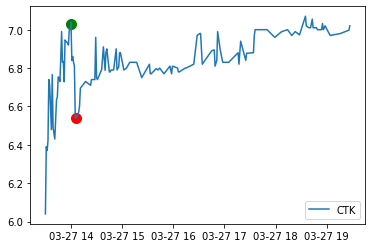

SPKE analysis for run 121 with profit -9.36


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-1612.26,-1612.26,buy,2020-03-27 14:55:45.729596,6.89,234,"{'rsi': 66.91260023262706, 'macd': [0.0762634646159217, 0.07790799194473053, 0.0759154365249115, 0.07668006761736201, 0.08159047582236045], 'sell_macd': [0.04530929692640839, 0.04625776772620949, 0.04483764409324653, 0.04522666926115537, 0.04831906979119971], 'slow macd': [0.04501578910632009, 0.047062676063826636, 0.048390799288523745, 0.050175064919420365, 0.05277598253518079], 'macd_signal': [0.0685783590611972, 0.07044428563790386, 0.07153851581530539, 0.07256682617571672, 0.07437155610504546], 'sell_macd_signal': [0.040902731944996024, 0.041973739101238715, 0.04254652009964028, 0.0430825499319433, 0.04412985390379458]}",7.94,6.56
1,-9.36,1602.90,sell,2020-03-27 16:48:08.361679,6.85,234,"{'rsi': 44.97815314500449, 'macd': [0.011365919338175878, 0.007914843191522358, 0.0035644612176168877, 0.0022061835597995128, -0.001478268947068706], 'reasons': 'below cost & macd negative', 'movement': -0.03107344632768358, 'macd_signal': [0.021289727591829635, 0.01861475071176818, 0.01560469281293792, 0.01292499096231024, 0.01004433898043445]}",7.94,6.56


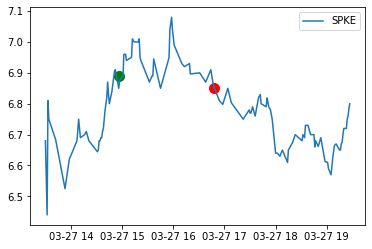

QUOT analysis for run 121 with profit -9.08


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-1611.70,-1611.70,buy,2020-03-27 13:53:19.411137,7.10,227,"{'rsi': 72.93941893919708, 'macd': [0.07080566672150024, 0.08045681742693844, 0.08670251308018084, 0.09060780154833115, 0.09303379335046191], 'sell_macd': [0.043872227047063284, 0.04994123653711213, 0.053762007093811626, 0.056041023019891334, 0.0573488143516423], 'slow macd': [0.03696802320120174, 0.04051541571330919, 0.04363436353718164, 0.04643410823473548, 0.04901566605805918], 'macd_signal': [0.05447298088258782, 0.05966974819145794, 0.06507630116920252, 0.07018260124502824, 0.07475283966611498], 'sell_macd_signal': [0.03381039018083508, 0.03703655945209049, 0.04038164898043471, 0.043513523788326035, 0.046280581900989284]}",8.17,6.74
1,-9.08,1602.62,sell,2020-03-27 14:40:20.122967,7.06,227,"{'rsi': 42.97329347932716, 'macd': [0.014767064380199812, 0.010940662419219649, 0.007297483457167964, 0.002805428636644791, -0.0003676715954084031], 'reasons': 'below cost & macd negative', 'movement': -0.003239436619718266, 'macd_signal': [0.022009399109140747, 0.01979565177115653, 0.017296018108358815, 0.01439790021401601, 0.011444785852131127]}",8.17,6.74


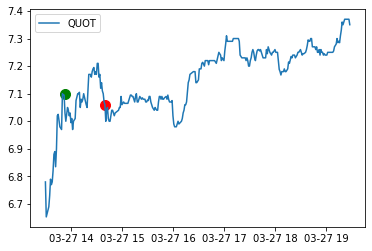

FNGD analysis for run 121 with profit -45.79


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-2094.29,-2094.29,buy,2020-03-27 13:48:10.653976,8.69,241,"{'rsi': 64.27334575652867, 'macd': [0.12809426011288672, 0.1252299264940433, 0.12321792805769682, 0.12495191300861741, 0.12688079679627862], 'sell_macd': [0.08061770026834658, 0.0782498567348231, 0.07646907142643045, 0.07715847155721, 0.07799230969084192], 'slow macd': [0.04113620674728935, 0.04413122019193594, 0.04714881357672951, 0.050794909987804004, 0.05446803601816619], 'macd_signal': [0.10156125936685814, 0.10629499279229518, 0.1096795798453755, 0.11273404647802389, 0.11556339654167483], 'sell_macd_signal': [0.06503943825447736, 0.06768152195054651, 0.0694390318457233, 0.07098291978802064, 0.07238479776858489]}",9.71,8.37
1,-45.79,2048.50,sell,2020-03-27 15:07:50.987471,8.50,241,"{'rsi': 35.630330677860265, 'macd': [0.010834595119387558, 0.008687310075846, 0.004802577443530964, 0.0012144406203837832, -0.004142736652463341], 'reasons': 'below cost & macd negative', 'movement': -0.023434807581849584, 'macd_signal': [0.012651294793957563, 0.011858497850335251, 0.010447313768974394, 0.008600739139256273, 0.00605204398091235]}",9.71,8.37


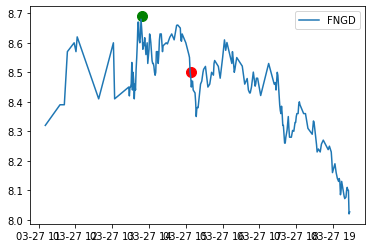

DWT analysis for run 121 with profit -3.58


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-2545.38,-2545.38,buy,2020-03-27 14:28:18.867092,14.22,179,"{'rsi': 66.86322445199443, 'macd': [0.04318599219253727, 0.047472251531768705, 0.05776408148094703, 0.06396464247838374, 0.07448343365895838], 'sell_macd': [0.022627627016033713, 0.025638574120643298, 0.03251933064214896, 0.03667421454666986, 0.04359653688075582], 'slow macd': [0.12082376239975368, 0.1201757988522072, 0.12088604782529266, 0.12110465586038721, 0.1223931798369211], 'macd_signal': [0.02994753976789482, 0.0334524821206696, 0.038314801992725085, 0.04344477008985682, 0.049652502803677126], 'sell_macd_signal': [0.012367587423709744, 0.015021784763096454, 0.018521293938906953, 0.022151878060459533, 0.02644080982451879]}",15.58,13.78
1,-3.58,2541.80,sell,2020-03-27 14:59:10.967766,14.20,179,"{'rsi': 43.41912744454207, 'macd': [0.016820445007219575, 0.011805653222257462, 0.00906418360771255, 0.003932334770302859, -0.0011045907493709706], 'reasons': 'below cost & macd negative', 'movement': -0.002037947997189031, 'macd_signal': [0.023194039994868947, 0.02091636264034665, 0.01854592683381983, 0.015623208421116436, 0.012277648587018955]}",15.58,13.78


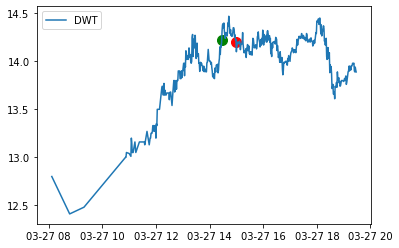

LABD analysis for run 121 with profit -27.37


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-1795.71,-1795.71,buy,2020-03-27 14:34:24.040185,15.09,119,"{'rsi': 63.95559940613883, 'macd': [0.06985945412037786, 0.06542627383756461, 0.06790824058080247, 0.06907891833598079, 0.07718609984404345], 'sell_macd': [0.0420809219580498, 0.039026654278149664, 0.04050350213435472, 0.04112827316341772, 0.04627577950861905], 'slow macd': [0.057865577744786734, 0.058050566296079964, 0.05947138052692402, 0.06068345890479776, 0.06330091532697679], 'macd_signal': [0.06832770757416054, 0.06774742082684135, 0.06777958477763357, 0.06803945148930302, 0.06986878116025111], 'sell_macd_signal': [0.04184430508238032, 0.04128077492153419, 0.04112532036409829, 0.04112591092396218, 0.04215588464089355]}",17.12,14.43
1,-27.37,1768.34,sell,2020-03-27 14:54:10.818449,14.86,119,"{'rsi': 42.99019153108107, 'macd': [0.01768331353549968, 0.014681560390597426, 0.011112901311575385, 0.0024735188953037834, -0.004290591025107204], 'reasons': 'below cost & macd negative', 'movement': -0.01589403973509935, 'macd_signal': [0.024774213201608185, 0.022755682639406034, 0.020427126373839904, 0.01683640487813268, 0.012611005697484703]}",17.12,14.43


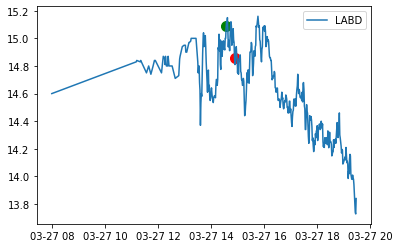

TECS analysis for run 121 with profit -51.68


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-1661.92,-1661.92,buy,2020-03-27 13:47:32.131913,6.11,272,"{'rsi': 67.53006764309983, 'macd': [0.09658234966106516, 0.09950414756197024, 0.09986961147222928, 0.10180187394924456, 0.10494764228366726], 'sell_macd': [0.06240505994337475, 0.06384789832683513, 0.06362870877723559, 0.06444455187135034, 0.06606151334895394], 'slow macd': [0.016154246118080806, 0.01973747384075608, 0.02284425396651102, 0.026224231596856384, 0.029851753228618882], 'macd_signal': [0.06272906958731934, 0.07008408518224953, 0.07604119044024547, 0.08119332714204529, 0.08594419017036968], 'sell_macd_signal': [0.041628952743150135, 0.046072741859887134, 0.04958393524335682, 0.052556058568955524, 0.05525714952495521]}",7.0,5.81
1,-51.68,1610.24,sell,2020-03-27 14:07:32.265819,5.92,272,"{'rsi': 44.81572032700625, 'macd': [0.008867831133266613, 0.007597375213064694, 0.0036515994932573292, 0.0010594158220662564, -0.000465135296031427], 'reasons': 'below cost & macd negative', 'movement': -0.027823240589198023, 'macd_signal': [0.021229182779471212, 0.01850282126618991, 0.015532576911603393, 0.012637944693695965, 0.010017328695750487]}",7.0,5.81


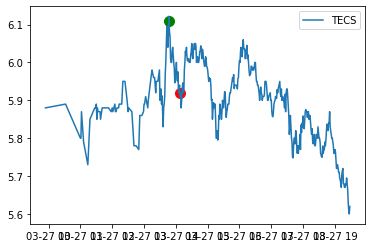

APVO analysis for run 121 with profit -43.4


,profit,trade,operation,at,price,qty,indicators,target price,stop price
0,-325.5,-325.5,buy,2020-03-27 14:39:21.663467,4.65,70,"{'rsi': 70.67293290630012, 'macd': [0.3370716640260758, 0.32935089273575535, 0.3267280560526187, 0.32812124034870704, 0.3302677951066251], 'sell_macd': [0.19078179065288392, 0.18600875218536927, 0.1845491280264575, 0.18568514649968826, 0.1872809382125995], 'slow macd': [0.4669598952549596, 0.46614688050973374, 0.4660927683742666, 0.4667353580994935, 0.46754129873338], 'macd_signal': [0.3124418322716493, 0.3158236443644705, 0.31800452670210017, 0.32002786943142153, 0.32207585456646226], 'sell_macd_signal': [0.17233975560002152, 0.17507355491709106, 0.17696866953896434, 0.17871196493110914, 0.1804257595874072]}",8.1,3.5
1,-43.4,282.1,sell,2020-03-27 14:55:49.393465,4.03,70,"{'rsi': 46.14168746368827, 'macd': [0.03066543313178638, 0.029136962957062806, 0.017177934730562505, 0.008155601895230014, -0.002617067871200085], 'reasons': 'below cost & macd negative', 'movement': -0.151578947368421, 'macd_signal': [0.09057044583339455, 0.0782837492581282, 0.06606258635261505, 0.054481189461138044, 0.04306153799467042]}",8.1,3.5


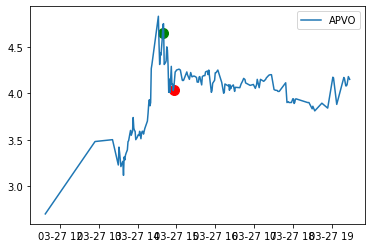

In [24]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
         
        plt.plot(minute_history[symbol]['close'], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        
        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

